# Calculate and plot the number of exchanged messages over time

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Global variables

In [2]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 500)

timeframe_upper_limit = 60 # Seconds after startup that you want to look at

In [5]:
paths =	{
  # set the topology size as key
  # "111": "../../logs/baseline/25-03-2021",
  "73": "../../logs/baseline/30-03-2021"  
}

exclude_paths = []

num_nodes = 73
height = 2
degree = 8

num_runs = {
  73: 9,
  111: 5
}

In [6]:
# naming: m_xxx = maintenance_xxx
# naming: d_xxx = data_xxx
d_stamps = []
d_topologies = []
d_node_ids = []
d_runs = []
d_latencies = []

startup_times = {}

for path in paths : 
    #print(path)
    for root, dirs, files in os.walk(paths[path]) :
        dirs[:] = [directory for directory in dirs if directory not in exclude_paths]
        # print(root)
        # print(dirs)
        # print(files)
        got_startup_time = False
        run = root.split('_')[-1]        
        for file in files :
            with open( os.path.join(root, file) ) as log :   
                node_id = file.split('_')[0][4:]              
                for line in log :            
                    if "DATA RECEIVED" in line:
                        # data messages
                        elem = line.split( )                
                        if not got_startup_time:
                            # get timestamp of the first data tuple
                            got_startup_time = True                            
                            startup_times[int(run)] = int(elem[8])
                        d_node_ids.append(int(node_id))                        
                        d_stamps.append( int(elem[8]) ) # unix timestamp
                        d_topologies.append( int(path) )
                        d_runs.append(int(run))
                        d_latencies.append(int(1000000*float(elem[-1])))
                    

d_data = pd.DataFrame(np.column_stack([d_topologies, d_runs, d_node_ids, d_latencies, d_stamps]), 
                        columns=['topology', 'run', 'node_id', 'latency_micros','timestamp'])
# print(startup_time)
d_data.head()

,topology,run,node_id,latency_micros,timestamp
0,73,0,0,337,1617055755123306095
1,73,0,0,339,1617055755623512077
2,73,0,0,331,1617055755712409973
3,73,0,0,300,1617055755934209334
4,73,0,0,277,1617055756123479018


In [34]:
d_data['timestamp'] = d_data.apply(lambda row: row.timestamp - startup_times[row.run], axis=1)
d_data['timestamp_sec'] = d_data['timestamp'].apply(lambda x: x // 1000000000)
d_data

,topology,run,node_id,latency_micros,timestamp,timestamp_sec
0,73,6,0,1611,0,0
1,73,6,0,315,63043855,0
2,73,6,0,358,498942616,0
3,73,6,0,278,563147537,0
4,73,6,0,62527,632788076,0
...,...,...,...,...,...,...
75637,73,1,0,130455,59910121721,59
75638,73,1,0,92385,59910293723,59
75639,73,1,0,62418,59915671359,59
75640,73,1,0,136415,59958723117,59


# Reduce timeframe

In [35]:
d_data = d_data[d_data.timestamp_sec <= timeframe_upper_limit]
d_data

,topology,run,node_id,latency_micros,timestamp,timestamp_sec
0,73,6,0,1611,0,0
1,73,6,0,315,63043855,0
2,73,6,0,358,498942616,0
3,73,6,0,278,563147537,0
4,73,6,0,62527,632788076,0
...,...,...,...,...,...,...
75637,73,1,0,130455,59910121721,59
75638,73,1,0,92385,59910293723,59
75639,73,1,0,62418,59915671359,59
75640,73,1,0,136415,59958723117,59


# Try to find outliers

In [36]:
d_outliers = d_data.groupby(['topology', 'run', 'node_id', 'timestamp_sec']).size().reset_index(name='number of messages').sort_values(by=['number of messages'], ascending=False, axis=0)
# d_outliers.head()

# Compute results

In [37]:
d_grouped = d_data.groupby(['topology', 'timestamp_sec']).size().reset_index(name='number of messages')
d_grouped['number of messages'] = d_grouped.apply(lambda row: row['number of messages'] / num_runs[row['topology']], axis=1)
d_grouped['number of messages per node'] = d_grouped.apply(lambda row: row['number of messages'] / row['topology'], axis=1)
# d_grouped

# Throughput

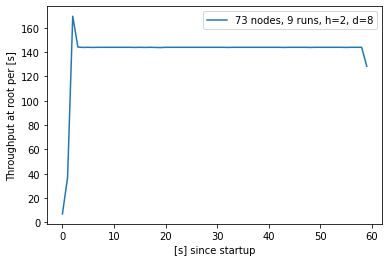

In [38]:
ax = plt.gca()

d_grouped.plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Throughput at root per [s]")

plt.legend([str(num_nodes) +' nodes, ' + str(num_runs[num_nodes]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
plt.savefig('baseline-throughput-paper.pdf')  

In [39]:
first_30 = d_grouped[d_grouped['timestamp_sec'] <= 30]['number of messages'].sum()
first_60 = d_grouped[d_grouped['timestamp_sec'] <= 50]['number of messages'].sum()
f_30_60 = d_grouped[(d_grouped['timestamp_sec'] >=5) & (d_grouped['timestamp_sec'] < 50)]['number of messages'].sum()

print('Overall exchanged data within first 30s: ' + str(first_30))
print('Overall exchanged data within first 60s: ' + str(first_60))
print('Overall exchanged data between 30s and 60s: ' + str(f_30_60))
print('Exchanged data between 30s and 60s per second per node: ' + str(f_30_60/(45*(num_nodes-1))))

print('\nOverall exchanged maintenance messages during first 30s per node: ' + str(first_30 / num_nodes))
print('\nOverall exchanged maintenance messages during first 50s per node: ' + str(first_60 / num_nodes))
print('\nOverall throughput at root: ' + str(first_60 / 50))

Overall exchanged data within first 30s: 4244.666666666667
Overall exchanged data within first 60s: 7124.333333333334
Overall exchanged data between 30s and 60s: 6479.0
Exchanged data between 30s and 60s per second per node: 1.9996913580246913

Overall exchanged maintenance messages during first 30s per node: 58.14611872146119

Overall exchanged maintenance messages during first 50s per node: 97.59360730593608

Overall throughput at root: 142.48666666666668


# Latency

In [40]:
d_latency = d_data.groupby(['topology', 'timestamp_sec'],  as_index=False)['latency_micros'].mean()
d_latency['latency_micros'] = d_latency['latency_micros'] / 1000  
d_latency.rename(columns = {'latency_micros':'latency_millis'}, inplace=True)
d_latency

,topology,timestamp_sec,latency_millis
0,73,0,23.35710
1,73,1,174.22962
2,73,2,227.84391
3,73,3,94.84901
4,73,4,94.17378
5,73,5,94.10301
6,73,6,94.18606
7,73,7,94.11949
8,73,8,94.11096
9,73,9,94.10548


In [41]:
d_latency = d_latency[d_latency["timestamp_sec"] >= 0]

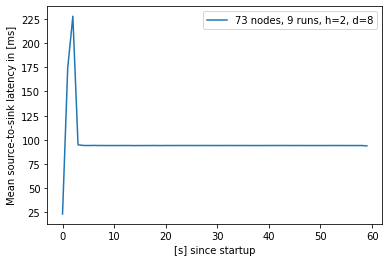

In [42]:
ax = plt.gca()

d_latency.plot(kind='line',x='timestamp_sec',y='latency_millis',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Mean source-to-sink latency in [ms]")

plt.legend([str(num_nodes) +' nodes, ' + str(num_runs[num_nodes]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
plt.savefig('baseline-latency-paper.pdf')  

In [43]:
avg_latency = d_latency['latency_millis'].mean()

print("Average latency per packet from source to sink: " + str(avg_latency))

Average latency per packet from source to sink: 96.501147069178
